# Drought Prediction: Modeling

#### Load Libraries and dataset (non-standardized).

In [1]:
#Import pandas, numpy, and StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
# Local location of the data
# local_data = 'D:\\Data_Science\\DroughtProject\\Data\\' # Location on Windows
local_data = '/home/chad/Data/Drought_Prediction/' # Location on Linux

# Load the dataset that contains training (meteorological variables) resampled weekly with mean, max, min
# and the soil variables that have been merged on the county 'fips' value
tsm = pd.read_csv(local_data + 'train_soil_stats.csv',
                        parse_dates=['date'],
                        index_col=['index'],
                        header=0)

In [3]:
# Confirm dataset loaded properly.
tsm

,fips,date,score,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
index,,,,,,,,,,,,,,,,,,,,,
0,1001,2000-01-04,1.0,5.005000,100.375000,9.562500,15.330000,12.707500,12.710000,21.145000,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-11,2.0,5.684286,100.665714,5.951429,9.192857,4.908571,4.934286,15.732857,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-18,2.0,0.832857,101.275714,6.692857,10.118571,6.711429,6.735714,16.931429,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-25,2.0,3.641429,100.187143,4.220000,4.458571,-0.224286,-0.132857,10.217143,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-02-01,1.0,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759899,56043,2016-12-06,0.0,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2759900,56043,2016-12-13,0.0,0.350000,82.865714,1.884286,-7.621429,-12.220000,-11.961429,-2.532857,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2759901,56043,2016-12-20,0.0,0.812857,82.752857,1.757143,-9.688571,-13.777143,-13.368571,-3.805714,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [4]:
# Confirming expected datatypes.
tsm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2759904 entries, 0 to 2759903
Data columns (total 88 columns):
 #   Column            Dtype         
---  ------            -----         
 0   fips              int64         
 1   date              datetime64[ns]
 2   score             float64       
 3   PRECTOT_mean      float64       
 4   PS_mean           float64       
 5   QV2M_mean         float64       
 6   T2M_mean          float64       
 7   T2MDEW_mean       float64       
 8   T2MWET_mean       float64       
 9   T2M_MAX_mean      float64       
 10  T2M_MIN_mean      float64       
 11  T2M_RANGE_mean    float64       
 12  TS_mean           float64       
 13  WS10M_mean        float64       
 14  WS10M_MAX_mean    float64       
 15  WS10M_MIN_mean    float64       
 16  WS10M_RANGE_mean  float64       
 17  WS50M_mean        float64       
 18  WS50M_MAX_mean    float64       
 19  WS50M_MIN_mean    float64       
 20  WS50M_RANGE_mean  float64       
 21  PRECTOT_

## Create Pipeline for Simple Linear Regression

In [5]:
# Breaking out independent numerical variables from target variable, categorical variable ('fips'), and date.
cols = tsm.columns.tolist()
features = cols[3:]

# Separating out the features
X = tsm[features]

# Separating out the target
y = tsm[['score']]

In [6]:
# Confirming X is as expected.
X

,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,T2M_MIN_mean,T2M_RANGE_mean,TS_mean,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
index,,,,,,,,,,,,,,,,,,,,,
0,5.005000,100.375000,9.562500,15.330000,12.707500,12.710000,21.145000,10.387500,10.752500,15.242500,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,5.684286,100.665714,5.951429,9.192857,4.908571,4.934286,15.732857,3.071429,12.662857,8.558571,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,0.832857,101.275714,6.692857,10.118571,6.711429,6.735714,16.931429,3.757143,13.177143,9.975714,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,3.641429,100.187143,4.220000,4.458571,-0.224286,-0.132857,10.217143,-1.282857,11.498571,4.508571,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,3.617143,100.992857,3.178571,0.764286,-2.791429,-2.714286,6.275714,-3.271429,9.547143,0.781429,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759899,0.471429,82.668571,1.991429,-5.320000,-11.062857,-10.812857,-0.422857,-9.621429,9.200000,-5.887143,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2759900,0.350000,82.865714,1.884286,-7.621429,-12.220000,-11.961429,-2.532857,-11.791429,9.260000,-8.364286,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2759901,0.812857,82.752857,1.757143,-9.688571,-13.777143,-13.368571,-3.805714,-15.451429,11.642857,-10.667143,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [7]:
# Inspecting target variable 'y'
y

,score
index,
0,1.0
1,2.0
2,2.0
3,2.0
4,1.0
...,...
2759899,0.0
2759900,0.0
2759901,0.0


In [8]:
# Converting 'y' from Panda Dataframe to Panda Series.
y = y.squeeze('columns')
y

index
0          1.0
1          2.0
2          2.0
3          2.0
4          1.0
          ... 
2759899    0.0
2759900    0.0
2759901    0.0
2759902    0.0
2759903    0.0
Name: score, Length: 2759904, dtype: float64

In [9]:
# Confirming data type.
type(y)

pandas.core.series.Series

In [10]:
# Confirming data type.
type(X)

pandas.core.frame.DataFrame

In [11]:
# Create pipeline for Linear Regression
LR_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LinearRegression()
)

### Create Cross-Validation for Simple Linear Regression

In [12]:
# Create cross validation for Linear Regression pipeline
lr_default_cv_results = cross_validate(LR_pipe, X, y, cv=5)

In [40]:
# R-squared mean value and standard deviation for the simple Linear Regression.
lr_cv_scores = lr_default_cv_results['test_score']
round(np.mean(lr_cv_scores), 5), round(np.std(lr_cv_scores),5)

(0.19025, 0.0483)

In [38]:
# Adjusted R-squared calculation as a baseline.
R2_mean = np.mean(lr_cv_scores)

Adj_R2 = 1 - (((1 - R2_mean)*(X.shape[0]))/(X.shape[0] - X.shape[1] - 1))
round(Adj_R2, 5)

0.19023

###  Initial Selection of Features for Linear Regression

In [14]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [15]:
pipe.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f4f07c99670>)),
                ('linearregression', LinearRegression())])

In [16]:
k = [k+1 for k in range(len(X.columns))]
grid_params = {'selectkbest__k': k}

In [17]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5)

In [18]:
lr_grid_cv.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f4f07c99670>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [19]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [20]:
lr_grid_cv.best_params_

{'selectkbest__k': 74}

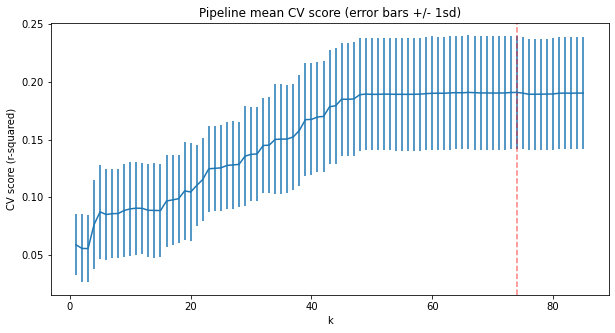

In [21]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [22]:
# Create a mask
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [23]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X.columns[selected]
display(pd.Series(coefs, index=features).sort_values(ascending=False))

CULT_LAND       134314.242637
T2MDEW_max          14.656425
T2M_MIN_mean         2.402326
T2M_MAX_mean         1.502543
T2M_min              1.203645
                    ...      
T2MDEW_mean         -1.837872
T2M_mean            -3.743574
T2MWET_max         -14.900519
CULTIR_LAND     -41764.664394
CULTRF_LAND    -129203.555552
Length: 74, dtype: float64

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.Series(coefs, index=features).sort_values(ascending=False))

CULT_LAND           134314.242637
T2MDEW_max              14.656425
T2M_MIN_mean             2.402326
T2M_MAX_mean             1.502543
T2M_min                  1.203645
T2MWET_mean              0.967445
TS_mean                  0.870162
TS_max                   0.822868
PS_min                   0.666998
T2MWET_min               0.580977
T2M_RANGE_mean           0.151002
SQ1                      0.139496
QV2M_max                 0.109526
WS10M_RANGE_mean         0.105873
T2M_MAX_min              0.100942
WS10M_mean               0.098911
PRECTOT_mean             0.069494
T2M_MAX_max              0.057805
WS10M_MIN_mean           0.037075
QV2M_mean                0.030144
T2M_RANGE_max            0.026396
WS50M_MIN_min            0.025948
WS10M_MAX_max            0.024940
WS10M_MAX_min            0.023753
WS10M_min                0.023469
WS10M_RANGE_max          0.018142
SQ4                      0.017603
slope4                   0.017179
WS10M_MAX_mean           0.017077
T2M_MIN_min   

In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(abs(pd.Series(coefs, index=features)).sort_values(ascending=False))

CULT_LAND           134314.242637
CULTRF_LAND         129203.555552
CULTIR_LAND          41764.664394
T2MWET_max              14.900519
T2MDEW_max              14.656425
T2M_mean                 3.743574
T2M_MIN_mean             2.402326
T2MDEW_mean              1.837872
T2M_MAX_mean             1.502543
TS_min                   1.241864
T2M_min                  1.203645
T2MDEW_min               1.004791
T2MWET_mean              0.967445
TS_mean                  0.870162
TS_max                   0.822868
PS_mean                  0.681065
PS_min                   0.666998
T2M_max                  0.620871
T2MWET_min               0.580977
T2M_RANGE_mean           0.151002
WS50M_RANGE_mean         0.145199
SQ1                      0.139496
QV2M_max                 0.109526
WS10M_RANGE_mean         0.105873
WS50M_MIN_mean           0.104610
T2M_MAX_min              0.100942
WS10M_mean               0.098911
lat                      0.093710
NVG_LAND                 0.087909
slope5        

In [32]:
# The variables with the largest coefficients from the simple linear regresssion.
top_features = abs(pd.Series(coefs, index=features)).sort_values(ascending=False)
top_features[:15]

CULT_LAND       134314.242637
CULTRF_LAND     129203.555552
CULTIR_LAND      41764.664394
T2MWET_max          14.900519
T2MDEW_max          14.656425
T2M_mean             3.743574
T2M_MIN_mean         2.402326
T2MDEW_mean          1.837872
T2M_MAX_mean         1.502543
TS_min               1.241864
T2M_min              1.203645
T2MDEW_min           1.004791
T2MWET_mean          0.967445
TS_mean              0.870162
TS_max               0.822868
dtype: float64

## Random Forest Regression Model

In [41]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

In [43]:
rf_default_cv_results = cross_validate(RF_pipe, X, y, cv=5)

In [44]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.29233164, 0.50011184, 0.4239188 , 0.42833261, 0.34352128])

In [45]:
round(np.mean(rf_cv_scores), 5), round(np.std(rf_cv_scores), 5)

(0.39764, 0.07232)

### Hyperparameter search using GridSearchCV

In [ ]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

In [ ]:
f_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5)

In [ ]:
rf_grid_cv.fit(X, y)

In [ ]:
rf_grid_cv.best_params_

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X, y, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
round(np.mean(rf_best_scores), 5), round(np.std(rf_best_scores), 5)

In [ ]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');